# IA353 - Redes Neurais
# EFC4 - Questão 9
# Generative Adversarial Networks

##### **Based on https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py**
##### **Based on https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/**

**Professor:** Fernando J. Von Zuben

**Aluno(a)**: Guilherme Rosa

### **1. Importações**

In [ ]:
from __future__ import print_function, division

from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive

import matplotlib.pyplot as plt
import sys
import numpy as np
import matplotlib.image as mpimg

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/'

### **2. Implementação da classe GAN_MNIST para o problema de geração de imagens de dígitos manuscritos da base MNIST**

In [ ]:
class GAN_MNIST():

    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)


    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)


    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
            
            if epoch == (epochs - 1):
                self.sample_images(epoch)


    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        
        if epoch == (30000 - 1):
            fig.savefig(path + "EFC4/Q9_Images_GAN_MNIST/30000.png") # Please, define the working directory appropriately
        else:
            fig.savefig(path + "EFC4/Q9_Images_GAN_MNIST/%d.png" % epoch) # Please, define the working directory appropriately
        
        plt.close()

### **3. Instância da classe GAN_MNIST e treinamento do modelo:**

In [ ]:
gan = GAN_MNIST()
gan.train(epochs=30000, batch_size=32, sample_interval=1000)

### **4. Imagens *fakes* de dígitos manuscritos produzidas pela rede generativa GAN_MNIST**


#### **4.1. Antes do treinamento:**

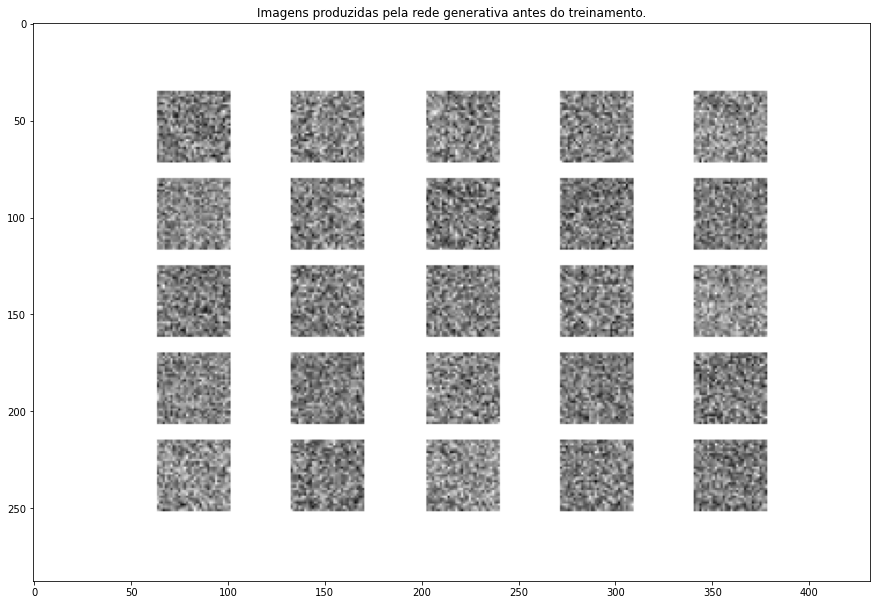

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_MNIST/0.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa antes do treinamento.')
plt.show()

#### **4.2. Durante o treinamento (1000 épocas):**


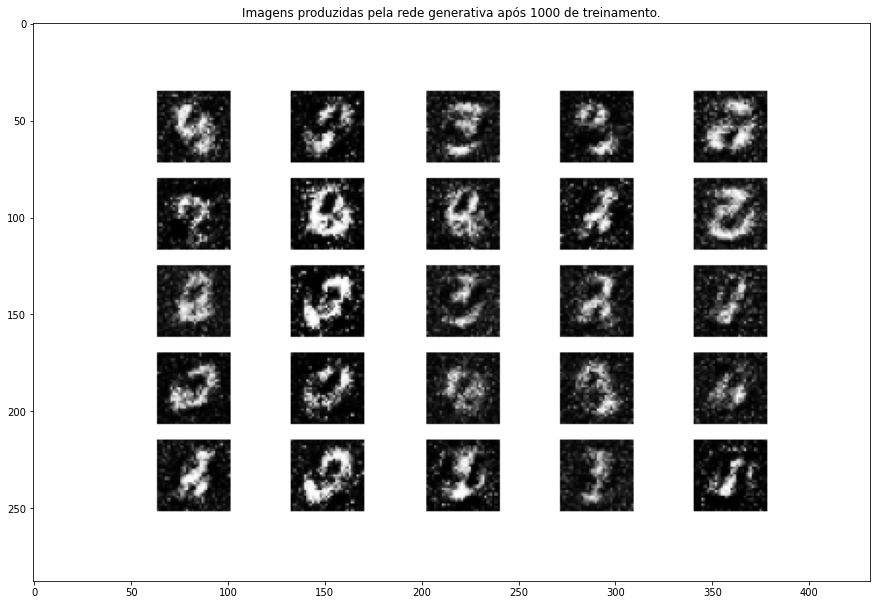

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_MNIST/1000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após 1000 de treinamento.')
plt.show()

#### **4.3. Durante o treinamento (10000 épocas):**

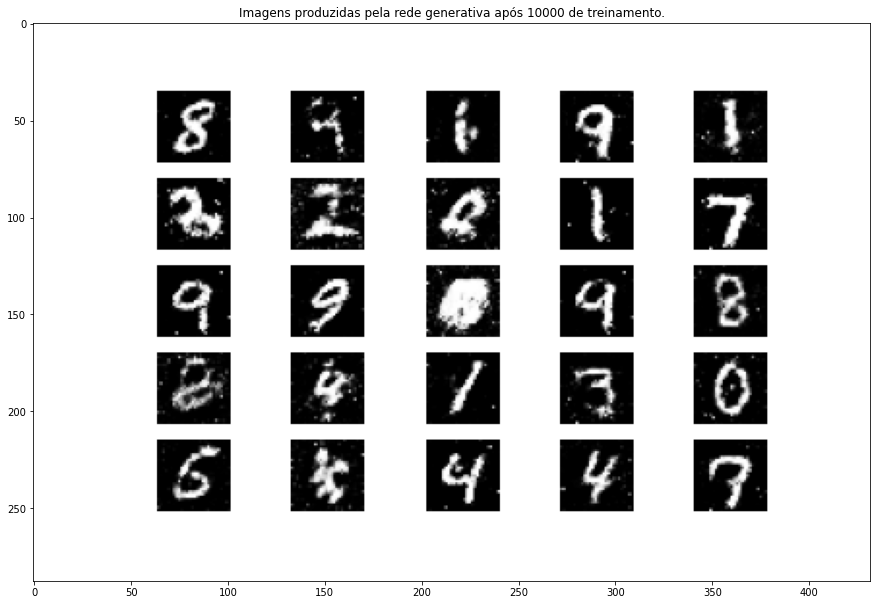

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_MNIST/10000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após 10000 de treinamento.')
plt.show()

#### **4.4. Durante o treinamento (20000 épocas):**

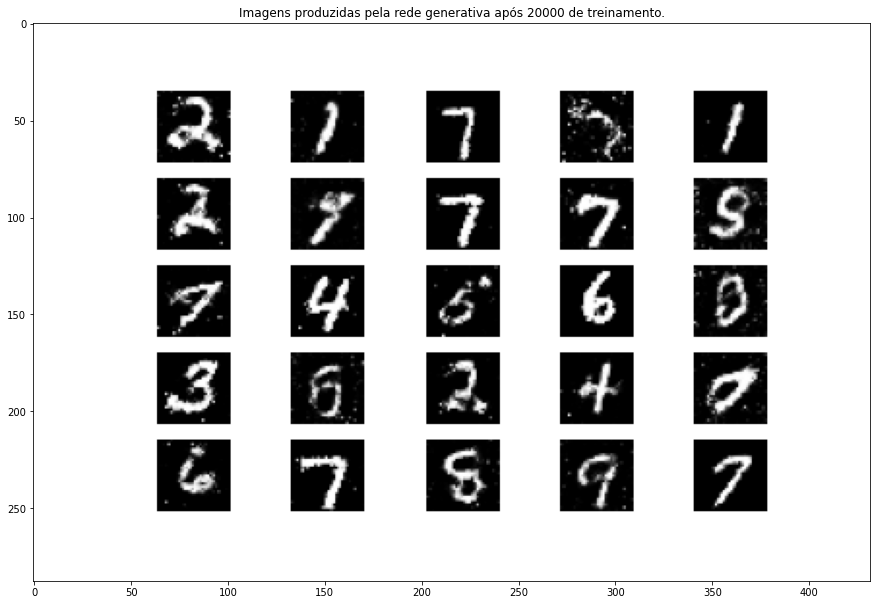

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_MNIST/20000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após 20000 de treinamento.')
plt.show()

#### **4.5. Após o treinamento:**

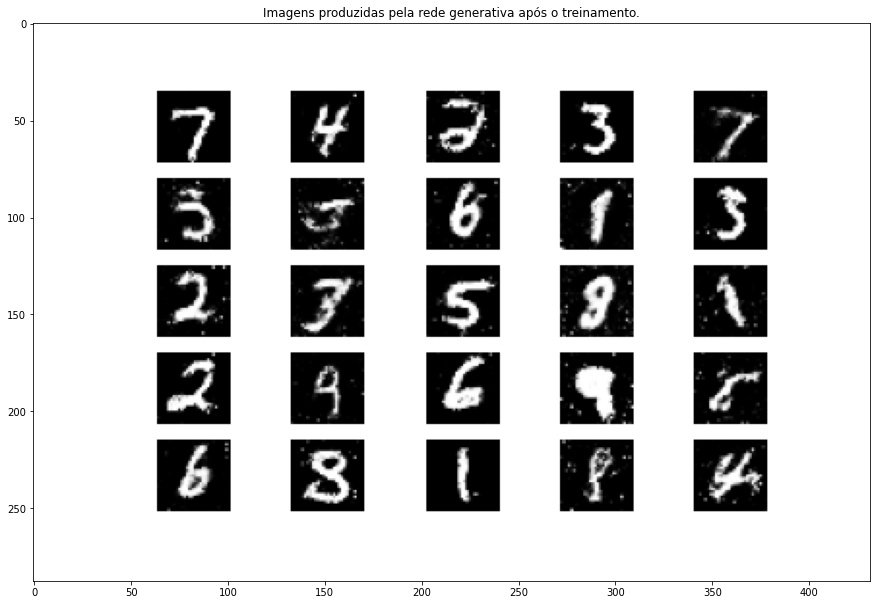

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_MNIST/30000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após o treinamento.')
plt.show()

### **5. Implementação da classe GAN_CIFAR10 para o problema de geração de imagens da base CIFAR10**

In [ ]:
class GAN_CIFAR10():

    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined.summary()


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256*4*4, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 256)))
        model.add(Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, kernel_size=(3, 3), activation='tanh', padding='same'))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        model.summary()

        return Model(noise, img)


    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)
        model.summary()

        return Model(img, validity)


    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = cifar10.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
            
            if epoch == (epochs - 1):
                self.sample_images(epoch)


    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        
        if epoch == (30000 - 1):
            fig.savefig(path + "EFC4/Q9_Images_GAN_CIFAR10/30000.png") # Please, define the working directory appropriately
        else:
            fig.savefig(path + "EFC4/Q9_Images_GAN_CIFAR10/%d.png" % epoch) # Please, define the working directory appropriately
        
        plt.close()

### **6. Instância da classe GAN_CIFAR10 e treinamento do modelo:**

In [ ]:
gan = GAN_CIFAR10()
gan.train(epochs=30000, batch_size=32, sample_interval=1000)

### **7. Imagens fakes da base CIFAR10 produzidas pela rede generativa GAN_CIFAR10**


#### **7.1. Antes do treinamento:**

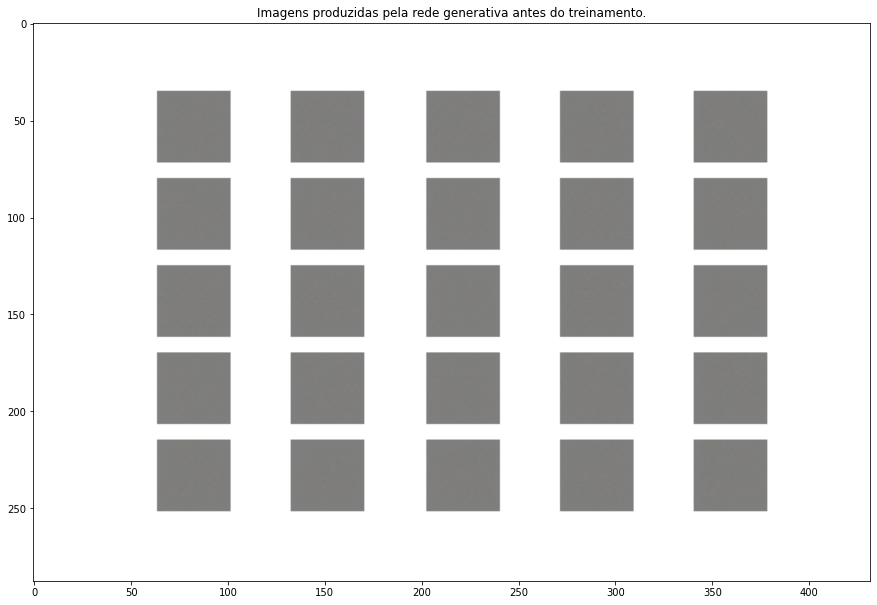

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_CIFAR10/0.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image) 
plt.title('Imagens produzidas pela rede generativa antes do treinamento.')
plt.show()

#### **7.2. Durante o treinamento (1000 épocas):**


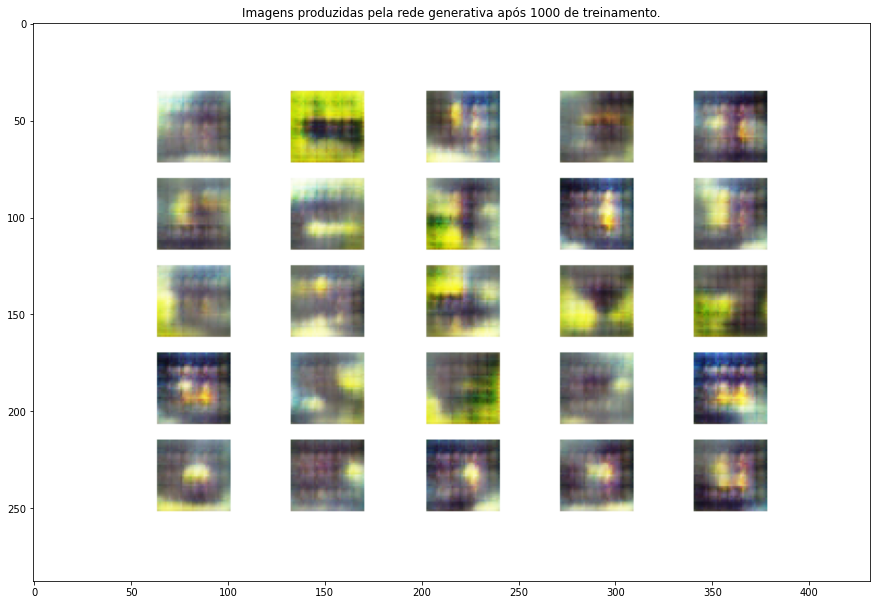

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_CIFAR10/1000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após 1000 de treinamento.')
plt.show()

#### **7.3. Durante o treinamento (10000 épocas):**


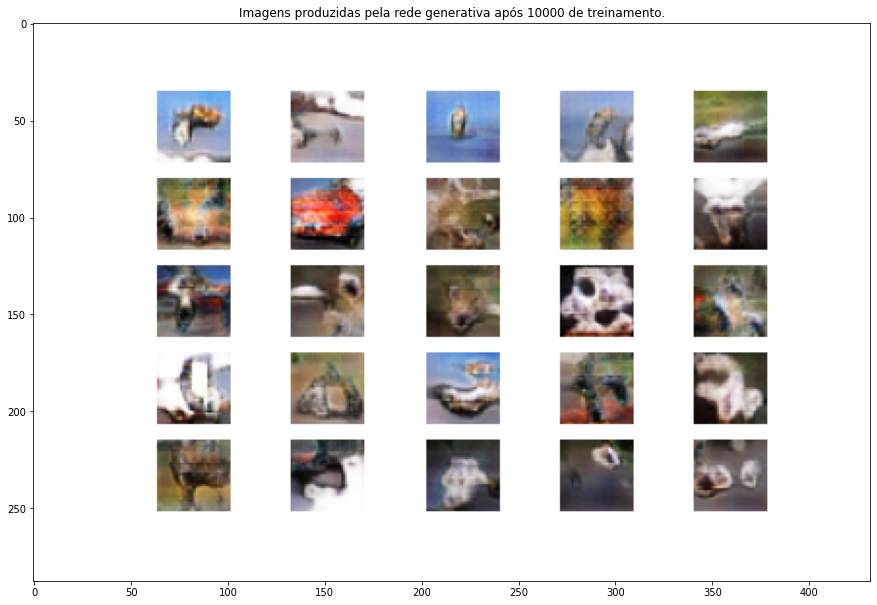

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_CIFAR10/10000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após 10000 de treinamento.')
plt.show()

#### **7.4. Durante o treinamento (20000 épocas):**


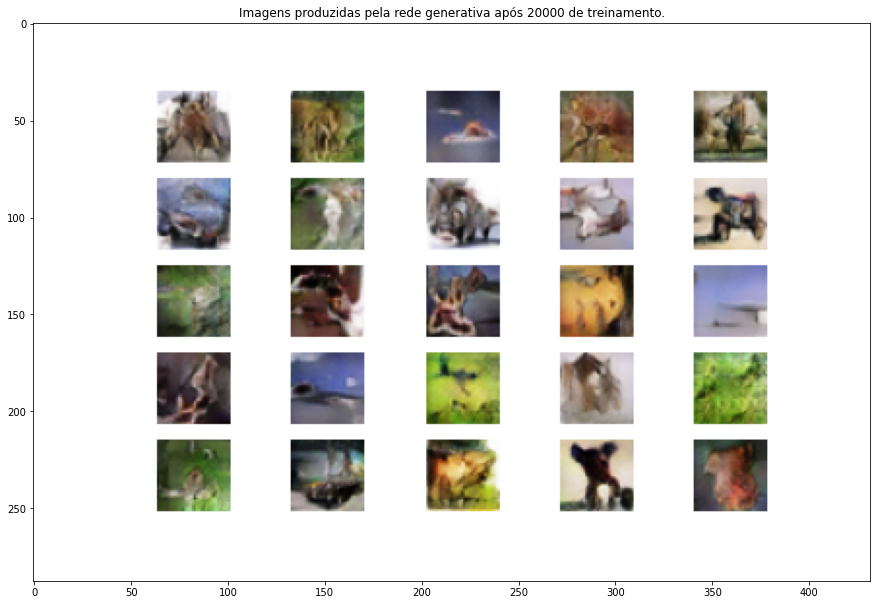

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_CIFAR10/20000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após 20000 de treinamento.')
plt.show()

#### **7.5. Após o treinamento:**

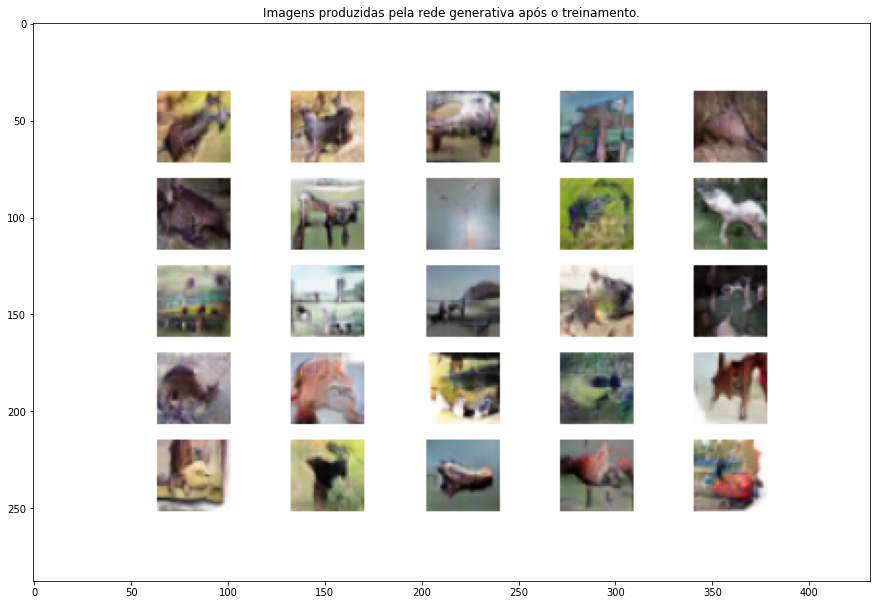

In [ ]:
image = mpimg.imread(path + "EFC4/Q9_Images_GAN_CIFAR10/30000.png") # Please, define the working directory appropriately
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title('Imagens produzidas pela rede generativa após o treinamento.')
plt.show()